In [1]:
%load_ext autoreload
%autoreload 2

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.signal

import os
import sys
import time
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import matplotlib_funs as mpf
import peak_finder as pkf
import general_funs as gef
import debug_funs as dgf
import numerical_funs as nf
import stats_funs as sf

import finesse
import finesse.ligo as aligo

In [132]:
code = '''
l L0 P=1

s lL0_IC L0.p1 OMC_IC.p1

cav cavOMC OMC_IC.p3.o
bs OMC_IC T=0.0076 L=10u alpha=0
s lIC_OC OMC_IC.p3 OMC_OC.p1 L=0.2815
bs OMC_OC T=0.0075 L=10u alpha=0
s lOC_CM1 OMC_OC.p2 OMC_CM1.p1 L=0.2842
bs OMC_CM1 T=36u L=10u alpha=0 Rc=2.57321
s lCM1_CM2 OMC_CM1.p2 OMC_CM2.p1 L=0.2815
bs OMC_CM2 T=35.9u L=10u alpha=0 Rc=2.57369
s lCM2_IC OMC_CM2.p2 OMC_IC.p4 L=0.2842
'''

kat = finesse.Model()
kat.parse(code)

In [148]:
def TMS(mode_sep_x, mode_sep_y, FWHM):
    return np.abs(mode_sep_x - mode_sep_y)/FWHM

def TMS(cav):
    mode_sep_x, mode_sep_y = cav.mode_separation
    FWHM = cav.FWHM
    return np.abs(mode_sep_x - mode_sep_y)/FWHM

def TMS_t(kat, CM1, CM2):
    with kat.temporary_parameters():
        kat.OMC_CM1.alpha = CM1
        kat.OMC_CM2.alpha = CM2
        tms = TMS(kat.cavOMC)
    return tms

In [178]:
np.sin(1.5/180*np.pi)*0.2815

0.0073688109486662904

In [161]:
TMS_t(kat, 4,5.5)

0.34590651214336099

In [193]:
out1 = []

a1s = np.linspace(2,7,41)
a2s = np.linspace(2,7,40)

for i,a1 in enumerate(a1s):
    dgf.inplace_print(i)
    t_ = []
    for a2 in a2s:
        t_.append(TMS_t(kat, a1, a2))
    out1.append(t_)
    
out1 = np.array(out1)

/tmp/ipykernel_30226/1942810597.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_LLO_OMC_TMS_splitting/../OMC_mirror_angle_vs_TMS_splitting.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_LLO_OMC_TMS_splitting/../OMC_mirror_angle_vs_TMS_splitting.pdf


0

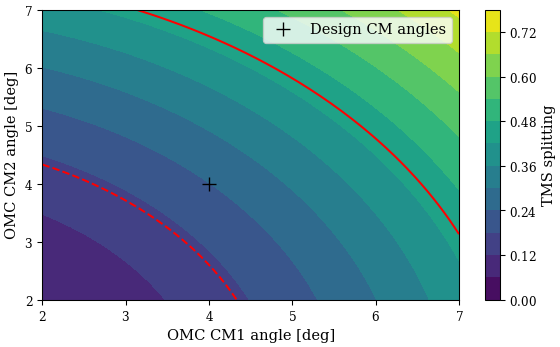

In [239]:
fig, ax = plt.subplots(1,1, figsize=[7,4])

plt.contourf(a2s, a1s, out1, levels=12)
cbar = plt.colorbar()
plt.plot(4,4,'+',c='k',ms=10, label='Design CM angles')
plt.xlabel('OMC CM1 angle [deg]')
plt.ylabel('OMC CM2 angle [deg]')
cbar.set_label('TMS splitting')
CS = plt.contour(a2s, a1s, out1, levels=[0.17,0.44], colors=['r'])
l0,l1 = CS.collections
l0.set_linestyle('--')
# l0.set_label('LLO TMS splitting')
# l1.set_label('LHO TMS splitting')

# ax.patches += [l0]
leg = plt.legend()

mpf.thesis_savefig(fig,'../OMC_mirror_angle_vs_TMS_splitting', resize=False)

In [45]:
N = 1001

# aIC = 2.7609 * np.abs(np.random.normal(1, 0.01, N))
# aOC  = 4.004 * np.abs(np.random.normal(1, 0.01, N))
aCM1 = 4.004 * np.abs(np.random.normal(1, 0.01, N))
aCM2 = 4.004 * np.abs(np.random.normal(1, 0.01, N))

In [136]:
out = [np.ones(N)*0.2397]
s_ = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

a_ = []

for s in s_[1:]:
    dgf.inplace_print(s)
    aCM1 = 4.004 + np.random.normal(0, s, N)
    aCM2 = 4.004 + np.random.normal(0, s, N)
    
    a_.append([aCM1, aCM2])
    
    temp = []
    for a3,a4 in np.vstack([aCM1,aCM2]).T:
        kat.OMC_CM1.alpha = a3
        kat.OMC_CM2.alpha = a4

        temp.append(TMS(kat.cavOMC))
    out.append(temp)

a_ = np.array(a_)
out = np.array(out)

Text(0, 0.5, 'TMS splitting')

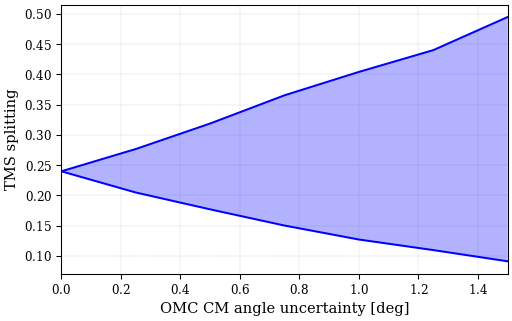

In [142]:
plt.plot(s_, np.quantile(out, 0.05, axis=1), c='b')
plt.plot(s_, np.quantile(out, 0.95, axis=1), c='b')
plt.fill_between(s_, np.quantile(out, 0.05, axis=1), np.quantile(out, 0.95, axis=1), alpha=0.3)
plt.xlabel('OMC CM angle uncertainty [deg]')
plt.ylabel('TMS splitting')

In [138]:
i1, i2 = np.where(out > 0.45)

In [147]:
np.sort(np.sum(np.abs(a_[i1-1,:,i2] - 4), axis=1))

array([ 2.66928983,  2.80574501,  2.81223783,  2.84368522,  2.8448081 ,
        2.8841844 ,  2.91401354,  2.91443436,  2.92381409,  2.92806862,
        2.93162936,  2.93349288,  2.97666466,  2.98216232,  2.98531466,
        2.99522654,  3.00644924,  3.00774713,  3.00947645,  3.01054096,
        3.0233003 ,  3.03814798,  3.04082455,  3.04291078,  3.04904681,
        3.05648377,  3.05798329,  3.06926337,  3.07241411,  3.0781837 ,
        3.08128072,  3.08284831,  3.08286392,  3.0880218 ,  3.0928679 ,
        3.10259489,  3.10404207,  3.12200612,  3.13345639,  3.1385531 ,
        3.14732643,  3.15266735,  3.15441164,  3.15556563,  3.15695327,
        3.16847002,  3.17518614,  3.17948937,  3.1796463 ,  3.18480614,
        3.19203606,  3.20936102,  3.21763134,  3.23956743,  3.24392774,
        3.24436886,  3.25137748,  3.25250326,  3.25572051,  3.25643194,
        3.27854575,  3.29385338,  3.31063509,  3.31695769,  3.33134663,
        3.33303829,  3.33597848,  3.339544  ,  3.35491713,  3.36